In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
numpy.random.seed(7)

dataframe = pandas.read_csv("passengers.csv", usecols=[1], engine="python", skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype("float32")

train_size = int(len(dataset) * 0.67) # 96
test_size = len(dataset) - train_size # 48
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

96 48


In [2]:
# window size로 독립변수와 종속변수를 분리한다.
def create_dataset(dataset, look_back=1): # look_back : 되돌아보는 size?
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back), 0] # 0 ~ 2
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) # 마지막
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
look_back = 2 # window size
# 원래는 vector 1개로부터 종속변수와 독립변수를 만들어낸다.
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX.shape
model = Sequential()

# 2x8 차원확대
model.add(Dense(8, input_dim=look_back, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="Adam")
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 0s - loss: 18395.9130
Epoch 2/200
 - 0s - loss: 10873.6136
Epoch 3/200
 - 0s - loss: 6018.2168
Epoch 4/200
 - 0s - loss: 3150.4389
Epoch 5/200
 - 0s - loss: 1744.4326
Epoch 6/200
 - 0s - loss: 1225.8595
Epoch 7/200
 - 0s - loss: 1070.8313
Epoch 8/200
 - 0s - loss: 1031.1837
Epoch 9/200
 - 0s - loss: 1019.4855
Epoch 10/200
 - 0s - loss: 1018.4849
Epoch 11/200
 - 0s - loss: 1020.3203
Epoch 12/200
 - 0s - loss: 1026.1770
Epoch 13/200
 - 0s - loss: 1017.8671
Epoch 14/200
 - 0s - loss: 1028.8512
Epoch 15/200
 - 0s - loss: 1017.2293
Epoch 16/200
 - 0s - loss: 1032.6344
Epoch 17/200
 - 0s - loss: 1008.3981
Epoch 18/200
 - 0s - loss: 1010.3988
Epoch 19/200
 - 0s - loss: 1021.0845
Epoch 20/200
 - 0s - loss: 1019.9763
Epoch 21/200
 - 0s - loss: 1015.8974
Epoch 22/200
 - 0s - loss: 1012.0281
Epoch 23/200
 - 0s - loss: 1008.1107
Epoch 24/200
 - 0s - loss: 1013.1912
Epoch 25/200
 - 0s - loss: 1003.0696
Epoch 26/200
 - 0s - loss: 1000.5357
Epoch 27/200
 - 0s - loss: 994.6274
Epoch 28/

In [9]:
# 데이터 분할(시계열 데이터 형태에 일치시킨다.)
# Boston housing 주택가격예측 - 독립변수 13개, 종속변수 존재했다.
# 지금한거는 종속변수가 없고, 자기상관성에 의해서 이전 2개를 보면 다음의 1개를 예측할 수 있다.
trainScore = model.evaluate(trainX, trainY, verbose=0)
print("Train Score: %.2f MSE (%.2f RMSE)" % (trainScore, math.sqrt(trainScore)))

Train Score: 719.58 MSE (26.82 RMSE)


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("austr.csv", skipfooter=2)
df.head()
df.info()
df.columns = ["Month", "beer"]
df.Month = pd.to_datetime(df.Month)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
Month                                                                                                                                                               476 non-null object
Monthly beer production in Australia: megalitres. Includes ale and stout. Does not include beverages with alcohol percentage less than 1.15. Jan 1956 ? Aug 1995    476 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


,Month,beer
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9
...,...,...
471,1995-04-01,127.0
472,1995-05-01,151.0
473,1995-06-01,130.0
474,1995-07-01,119.0


In [3]:
df = df.set_index("Month") # 인덱스를 시간
df.head()
df.index.freq = "MS" # 월 단위의 데이터

[Text(0, 0.5, 'Total Production'), Text(0.5, 0, 'Dates')]

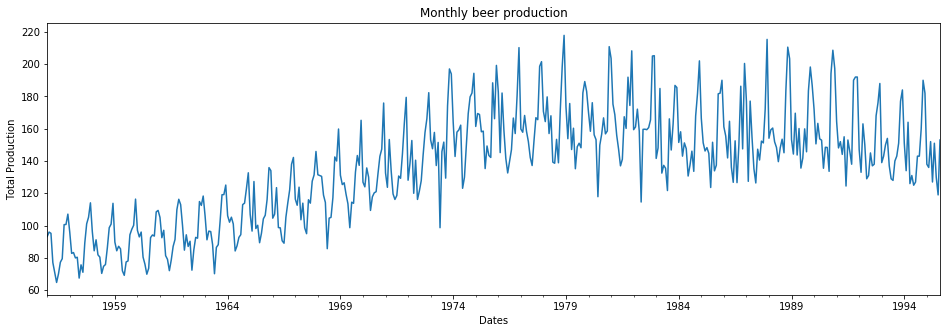

In [4]:
ax = df["beer"].plot(figsize=(16,5), title="Monthly beer production")
ax.set(xlabel="Dates", ylabel="Total Production")

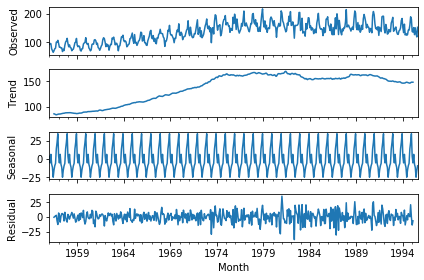

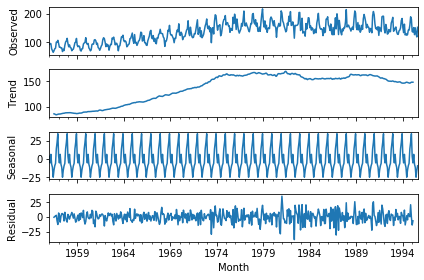

In [5]:
# Trend 경향성, Seasonal 계절성, Residual 기타
a = seasonal_decompose(df["beer"], model="add")
a.plot()

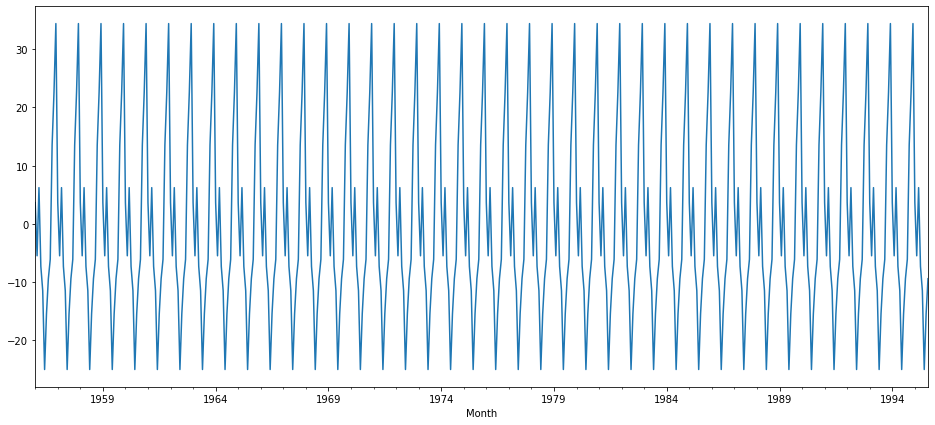

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,7))
a.seasonal.plot()

In [7]:
# P, D, Q (대문자) - 계절성  모델
# p, d, q (소문자) - 비계절성 모델
auto_arima(df["beer"],
           seasonal=True, m=12, # m=12 :계절성 주기
           # max_ : 상한값.. 경험을 통하여 습득하라..
           max_p=7, max_d=5, max_q=7, max_P=4, max_D=4, max_Q=4).summary()
# Ljung-Box (Q) : 자기상관성
# Jarque-Bera (JB) : 정규분포의 적합도 정도 확인


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  476
Model:             SARIMAX(3, 1, 4)x(2, 0, 2, 12)   Log Likelihood               -1729.085
Date:                            Tue, 11 Feb 2020   AIC                           3484.170
Time:                                    11:46:01   BIC                           3538.293
Sample:                                         0   HQIC                          3505.454
                                            - 476                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.215e-05      0.004      0.023      0.982      -0.007       0.007
ar.L1         -0.3337      0.042     -8.032      0.000      -0.415      -0.252
ar.L2         -0.0539      0.048     -1.135      0.256      -0.147       0.039
ar.L3          0.8081      0.041     19.537      0.000       0.727       0.889
ma.L1         -0.7349      0.035    -20.830      0.000      -0.804      -0.666
ma.L2         -0.1956      0.032     -6.181      0.000      -0.258      -0.134
ma.L3         -0.7911      0.030    -26.463      0.000      -0.850      -0.733
ma.L4          0.8468      0.032     26.745      0.000       0.785       0.909
ar.S.L12       0.0527      0.070      0.750      0.453      -0.085       0.191
ar.S.L24       0.9440      0.071     13.276      0.000       0.805       1.083
ma.S.L12       0.1050      0.058      1.804      0.071      -0.009       0.219
ma.S.L24      -0.8349      0.072    -11.619      0.000      -0.976      -0.694
sigma2        78.4800      4.178     18.785      0.000      70.292      86.668
===================================================================================
Ljung-Box (Q):                       51.16   Jarque-Bera (JB):                79.43
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# SARIMAX : 계절성을 고려한 ARIMA(비정상적 시계열)
# State ARIMA 아리마모형(비정상적 데이터 분석 가능)
# AR, MR, ARIMA -> 정상성을 띈 시계열 분석 모델
train_data = df[: len(df) - 12]
test_data = df[len(df) - 12 :]

arima_model = SARIMAX(train_data["beer"], # P,D,Q 옵션 설정 필요
                      order=(2,1,1),
                      seasonal_order=(4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               beer   No. Observations:                  464
Model:             SARIMAX(2, 1, 1)x(4, 0, 3, 12)   Log Likelihood               -1707.869
Date:                            Tue, 11 Feb 2020   AIC                           3437.739
Time:                                    11:46:21   BIC                           3483.254
Sample:                                01-01-1956   HQIC                          3455.657
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1184      0.043     -2.774      0.006      -0.202      -0.035
ar.L2         -0.1782      0.047     -3.756      0.000      -0.271      -0.085
ma.L1         -0.8477      0.028    -30.763      0.000      -0.902      -0.794
ar.S.L12       1.7620      0.120     14.667      0.000       1.527       1.997
ar.S.L24      -1.6228      0.237     -6.854      0.000      -2.087      -1.159
ar.S.L36       0.8021      0.190      4.232      0.000       0.431       1.173
ar.S.L48       0.0574      0.068      0.849      0.396      -0.075       0.190
ma.S.L12      -1.5522      0.132    -11.799      0.000      -1.810      -1.294
ma.S.L24       1.3925      0.223      6.250      0.000       0.956       1.829
ma.S.L36      -0.6660      0.131     -5.080      0.000      -0.923      -0.409
sigma2        85.9626      5.215     16.485      0.000      75.742      96.183
===================================================================================
Ljung-Box (Q):                       94.58   Jarque-Bera (JB):                40.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.04   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
arima_pred = arima_result.predict(start=len(train_data),
                                  end=len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

1994-09-01    134.239711
1994-10-01    157.427722
1994-11-01    181.648455
1994-12-01    183.633645
1995-01-01    144.817620
1995-02-01    136.920232
1995-03-01    151.413493
1995-04-01    133.176651
1995-05-01    137.919284
1995-06-01    120.677136
1995-07-01    128.296440
1995-08-01    138.992531
Freq: MS, Name: ARIMA Predictions, dtype: float64

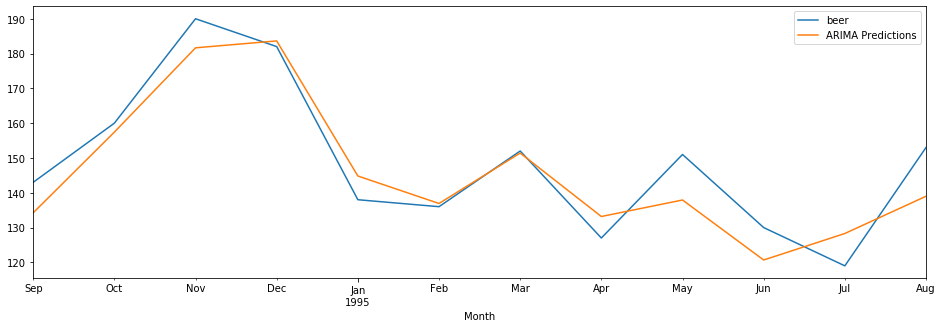

In [10]:
test_data["beer"].plot(figsize=(16,5), legend=True)
arima_pred.plot(legend=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
data = np.array([[i] for i in range(50)])
targets = np.array([[i] for i in range(50)])
data_gen = TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=2, batch_size=2)
assert len(data_gen) == 20
batch_0 = data_gen[0]
batch_0

(array([[[0],
         [2],
         [4],
         [6],
         [8]],
 
        [[1],
         [3],
         [5],
         [7],
         [9]]]), array([[10],
        [11]]))

In [16]:
x, y = batch_0

In [17]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train_data,
                                scaled_train_data, length=n_input, batch_size=1)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation="relu",
                    input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [19]:
lstm_model.fit_generator(generator, epochs=20)


Epoch 1/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0247
Epoch 2/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0151
Epoch 3/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0101
Epoch 4/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0087
Epoch 5/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0078
Epoch 6/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0073
Epoch 7/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0079
Epoch 8/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0070
Epoch 9/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0075
Epoch 10/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0070
Epoch 11/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0064
Epoch 12/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0067
Epoch 13/20
452/452 [===

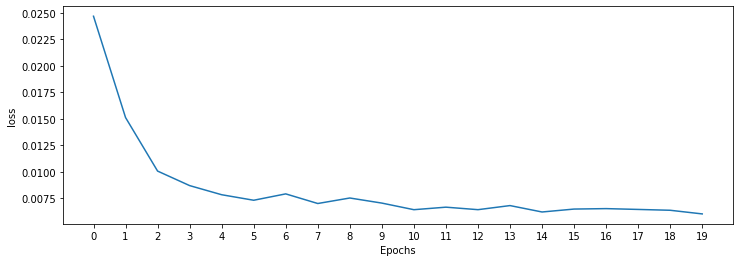

In [21]:
losses_lstm = lstm_model.history.history["loss"]
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [63]:
#Embeddings
import re
import numpy as np
from keras.preprocessing.sequence import pad_sequences # padding
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense # vectorization

In [64]:
docs = ['Well done!', 'Good work', 'Great effort', 'nice work', 'Excellent!',
        'Weak', 'Poor effort!', 'not good', 'poor work', 'Could have done better.']
labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0] 

In [65]:
own_embedding_vocab_size = 10
encoded_docs_oe = [one_hot(d, own_embedding_vocab_size) for d in docs]
print(encoded_docs_oe)

[[5, 5], [2, 8], [6, 5], [7, 8], [9], [3], [4, 5], [9, 2], [4, 8], [2, 1, 5, 2]]


In [66]:
maxlen = 5
padded_docs_oe = pad_sequences(encoded_docs_oe,
                               maxlen=maxlen,
                               padding="post")
print(padded_docs_oe)

[[5 5 0 0 0]
 [2 8 0 0 0]
 [6 5 0 0 0]
 [7 8 0 0 0]
 [9 0 0 0 0]
 [3 0 0 0 0]
 [4 5 0 0 0]
 [9 2 0 0 0]
 [4 8 0 0 0]
 [2 1 5 2 0]]


In [67]:
model = Sequential()
model.add(Embedding(input_dim=own_embedding_vocab_size,
                    output_dim=32,
                    input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

In [68]:
model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(padded_docs_oe, labels, epochs=50, verbose=0)
loss, accuracy = model.evaluate(padded_docs_oe, labels, verbose=0)
print("Accuracy: %0.3f" % accuracy)

Accuracy: 0.900


In [69]:
# 문제 : "Good work"에 대하여 예측해보시요.

In [70]:
word = "Good work"
word_docs_oe = [one_hot(word, own_embedding_vocab_size)]
word_oe = pad_sequences(word_docs_oe, maxlen=maxlen,
                        padding="post")
pred = model.predict(word_oe)

import numpy as np
np.round(pred)

array([[1.]], dtype=float32)

In [71]:
# 11,228 newswires : Reuters, labled over 46 topics

In [72]:
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout

In [73]:
max_words = 1000
batch_size = 100
nb_epoch = 200
(X_train, y_train), (X_test, y_test) = reuters.load_data(nb_words=max_words, test_split=0.2)
nb_classes = np.max(y_train) + 1
tokenizer = Tokenizer(nb_words=max_words)

In [74]:
X_train = tokenizer.sequences_to_matrix(X_train, mode="binary")
X_test = tokenizer.sequences_to_matrix(X_test, mode="binary")
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [75]:
model = Sequential()
# (8982, 1000)
model.add(Dense(512,
                input_shape=(max_words,),
                activation="relu"))
model.add(Dropout(0.5))
# 46개의 클래스
model.add(Dense(nb_classes, activation="softmax"))
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [77]:
history = model.fit(X_train, y_train, nb_epoch=nb_epoch,
                    batch_size=batch_size, verbose=0,
                    validation_split=0.1)
score = model.evaluate(X_test, y_test, batch_size=batch_size,
                       verbose=1)
print("\nModel Accuracy: %.2f%%" % score[1] * 100)
print("\nModel Loss: %.2f%%" % score[0] * 100)

2246/2246 [==============================] - 0s 23us/step

Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0.78%
Model Accuracy: 0

In [ ]:
#conda install nltk
#conda install gensim
#pip install Pyro4
#pip install jpype1==0.7.0
#pip install konlpy
#pip install simplejson
#pip install pygame
#pip install pytagcloud

In [2]:
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from konlpy.tag import Twitter
res = requests.get("http://sports.v.daum.net/v/20181227140914322")

In [3]:
soup = BeautifulSoup(res.content, "html.parser")
body = soup.select(".article_view")[0]
text = " ".join(p.get_text() for p in body.find_all("p"))
t = Twitter()
tokens_ko = t.nouns(text)
ko = nltk.Text(tokens_ko, name="스포츠")
ko.vocab().most_common(10)
data = ko.vocab().most_common(500)
tmp_data = dict(data)

C:\Users\ICT01_24\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


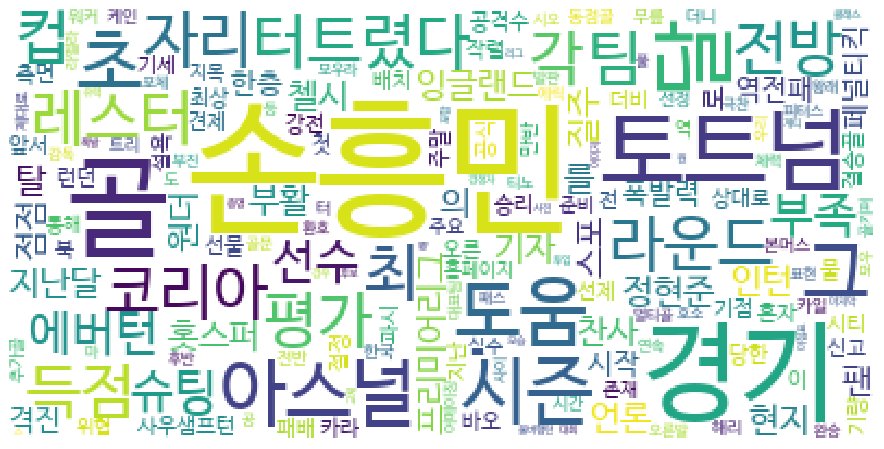

In [8]:
wordcloud = WordCloud(font_path="/Library/Fonts/NanumBarunGothic.ttf",
                      background_color="white",).generate_from_frequencies(tmp_data)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

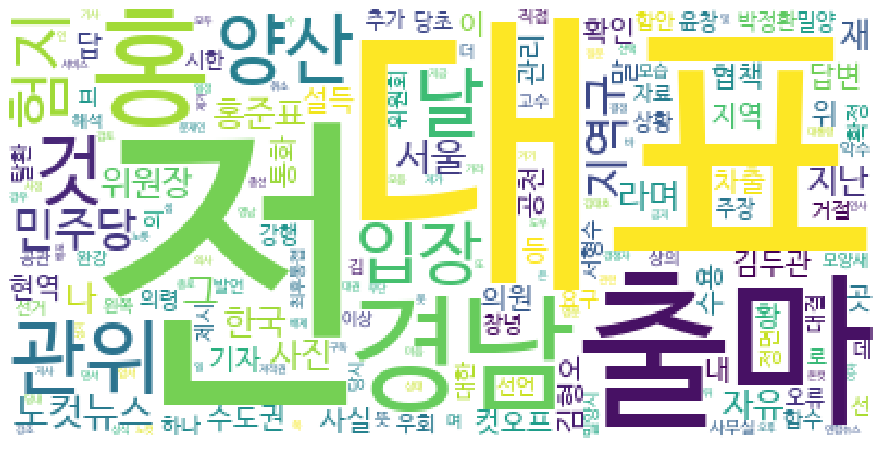

In [36]:
# 문제 : 오늘 뉴스 중에 한 페이지를 선택해서 wordcloud를 출력하세요.
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from konlpy.tag import Twitter
#res = requests.get("https://news.v.daum.net/v/20200211152915377") # 다음 뉴스
res = requests.get("https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=079&aid=0003321490") #네이버 뉴스

soup = BeautifulSoup(res.content, "html.parser")

#body = soup.select(".article_view")[0] # 다음 뉴스
body = soup.select("#articleBodyContents") # 네이버 뉴스

#text = " ".join(p.get_text() for p in body.find_all("p")) # 다음 뉴스
text = body[0].getText() # 네이버 뉴스

t = Twitter()
tokens_ko = t.nouns(text)
ko = nltk.Text(tokens_ko)
ko.vocab().most_common(10)
data = ko.vocab().most_common(500)
tmp_data = dict(data)
wordcloud = WordCloud(font_path="/Library/Fonts/NanumBarunGothic.ttf",
                      background_color="white",).generate_from_frequencies(tmp_data)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [37]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.datasets import imdb
import numpy as np
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=2000)
x_train = sequence.pad_sequences(x_train, maxlen=80)
x_test = sequence.pad_sequences(x_test, maxlen=80)
print(x_train[1])

17465344/17464789 [==============================] - 7s 0us/step
[ 125   68    2    2   15  349  165    2   98    5    4  228    9   43
    2 1157   15  299  120    5  120  174   11  220  175  136   50    9
    2  228    2    5    2  656  245    2    5    4    2  131  152  491
   18    2   32    2 1212   14    9    6  371   78   22  625   64 1382
    9    8  168  145   23    4 1690   15   16    4 1355    5   28    6
   52  154  462   33   89   78  285   16  145   95]


In [38]:
model = Sequential()
# 단어장의 크기
model.add(Embedding(2000, 128)) # 벡터로 변환
# 셀의 가중치 4개 셀의 크기
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid")) # 긍정/부정 2개의 분류
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [39]:
model.fit(x_train, y_train, batch_size=32, epochs=15,
          validation_data=(x_test, y_test))


Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 67s 3ms/step - loss: 0.4863 - accuracy: 0.7638 - val_loss: 0.3875 - val_accuracy: 0.8265
Epoch 2/15
25000/25000 [==============================] - 70s 3ms/step - loss: 0.3973 - accuracy: 0.8284 - val_loss: 0.3905 - val_accuracy: 0.8254
Epoch 3/15
25000/25000 [==============================] - 71s 3ms/step - loss: 0.3618 - accuracy: 0.8428 - val_loss: 0.3834 - val_accuracy: 0.8281
Epoch 4/15
25000/25000 [==============================] - 71s 3ms/step - loss: 0.3277 - accuracy: 0.8604 - val_loss: 0.3702 - val_accuracy: 0.8344
Epoch 5/15
25000/25000 [==============================] - 71s 3ms/step - loss: 0.3031 - accuracy: 0.8703 - val_loss: 0.3833 - val_accuracy: 0.8325
Epoch 6/15
25000/25000 [==============================] - 71s 3ms/step - loss: 0.2799 - accuracy: 0.8824 - val_loss: 0.3922 - val_accuracy: 0.8372
Epoch 7/15
25000/25000 [==============================] - 71s 3ms/s

In [123]:
dictionary = imdb.get_word_index(path="imdb_word_index.json")
imdb_key = dictionary.keys()
list(imdb_key)[1]

'tsukino'

In [148]:
# 문제 : x_train[1]을 문장으로 변환해보시요.
# model.summary를 해보고 가중치 사이즈를 계산해보시요.
model.summary()

xt = x_train[1]
rev_dictionary = dict([(value, key) for (key, value) in dictionary.items()])
sentence = " ".join([rev_dictionary.get(i) for i in xt])
print(sentence)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 387,713
Trainable params: 387,713
Non-trainable params: 0
_________________________________________________________________
better were and and for budget look and any to of making it out and follows for effects show to show cast this family us scenes more it and making and to and finds tv and to of and these thing wants but and an and cult as it is video do you david see scenery it in few those are of ship for with of wild to one is very work dark they don't do dvd with those them
